In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.base import AutoML
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures, LGBAdvancedPipeline
from lightautoml.pipelines.features.linear_pipeline import LinearFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ModelBasedImportanceEstimator, ImportanceCutoffSelector
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task

# Everything for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Sveta\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 1
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.1
TIMEOUT = 6*3600
TARGET_NAME = 'Рейтинг'

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [5]:
%%time

df = pd.read_csv('bo_rates.csv')
rates = pd.read_csv('na_ratings.csv')
df = df.apply(pd.to_numeric, errors='coerce').astype('Int64')
rates['ИНН'] = rates['ИНН'].astype('Int64')
df = pd.merge(df, rates[['ИНН', 'Рейтинг']], on='ИНН')

CPU times: total: 78.1 ms
Wall time: 155 ms


In [6]:
df['Рейтинг'] = df['Рейтинг'].str.split('[|]|.esg|.am').str[0].str.strip()
df['Рейтинг'] = df['Рейтинг'].str.replace('-', '–').str.replace('А', 'A').str.replace('В', 'B').str.replace('Независимое мнение НРA', '—').str.replace('1', '+').str.replace('2', '+')
df['Рейтинг'].nunique()

19

# regression

In [6]:
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task

In [7]:
rating_to_number = {
    'AAA': 100,
    'AA+': 90,
    'AA': 85,
    'AA–': 80,
    'A+': 75,
    'A': 70,
    'A–': 65,
    'BBB+': 60,
    'BBB': 55,
    'BBB–': 50,
    'BB+': 45,
    'BB': 40,
    'BB–': 35,
    'B+': 30,
    'B': 25,
    'B–': 20,
    'CCC': 15,
    'C': 10,
    '—': 0  # Отсутствующий или не определённый рейтинг
}

df['Рейтинг'] = df['Рейтинг'].map(rating_to_number)

In [8]:
df['Рейтинг'].mean()

62.14456188203205

In [9]:
for task_params, target in zip(
    [
        {"name": "reg", "loss": "mse", "metric": "r2"},
        {"name": "reg", "loss": "rmsle", "metric": "rmsle"},
        {
            "name": "reg",
            "loss": "quantile",
            "loss_params": {"q": 0.9},
            "metric": "quantile",
            "metric_params": {"q": 0.9},
        },
    ],
    ["num_sold", "num_sold", "num_sold"],
):
    task = Task(**task_params)
    print("Task created")

    reader = PandasToPandasReader(task, cv=5, random_state=1)
    print("Reader created")

    # pipeline 1
    pipe = LGBSimpleFeatures()

    params_tuner1 = OptunaTuner(n_trials=20, timeout=30)
    model1 = BoostLGBM(
        default_params={'learning_rate': 0.05, 'num_leaves': 128,
                        'seed': 1, 'num_threads': N_THREADS}
    )
    model2 = BoostLGBM(
        default_params={'learning_rate': 0.04, 'num_leaves': 64,
                        'seed': 2, 'max_depth': 8, 'num_threads': N_THREADS}
    )
    pipeline_lvl1 = MLPipeline([
        (model1, params_tuner1),
        model2],
        pre_selection=None, 
        features_pipeline=pipe,
        post_selection=None
    )
    print("Pipeline1 created")
    #pipeline2
    pipe1 = LGBSimpleFeatures()
    model = BoostLGBM(
        default_params={'learning_rate': 0.05, 'num_leaves': 64,
                        'max_bin': 1024, 'seed': 3, 'max_depth': 8, 'num_threads': N_THREADS},
        freeze_defaults=True
    )
    pipeline_lvl2 = MLPipeline(
        [model], 
        pre_selection=None, 
        features_pipeline=pipe1,
        post_selection=None
    )
    print("Pipeline2 created")
\
    automl = AutoML(reader, [
        [pipeline_lvl1],
        [pipeline_lvl2],], 
        skip_conn=False)

Task created
Reader created
Pipeline1 created
Pipeline2 created
Task created
Reader created
Pipeline1 created
Pipeline2 created
Task created
Reader created
Pipeline1 created
Pipeline2 created


In [10]:
train_data, test_data = train_test_split(df, 
                                    test_size=TEST_SIZE, 
                                    stratify=df['Рейтинг'], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(train_data.shape, test_data.shape))

Data splitted. Parts sizes: tr_data = (7919, 70), te_data = (880, 70)


In [11]:
start_time = time.time()
oof_pred = automl.fit_predict(train_data, roles={"target": 'Рейтинг'}, verbose=2)
print("AutoML pipeline fitted and predicted. Time = {:.3f} sec".format(time.time() - start_time))

[07:45:16] Train data shape: (7919, 70)

[07:45:24] Layer 1 train process start. Time left 9999999991.47 secs
[07:45:24] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_LightGBM ... Time budget is 30.00 secs
[07:45:24] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:25] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:26] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[07:45:26] Lvl_0_Pipe_0_

In [12]:
test_pred = automl.predict(test_data.drop(columns='Рейтинг'))
print("Check scores...")
print("OOF score: {}".format(task.metric_func(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

Check scores...
OOF score: 34.070779138780146


In [13]:
len(test_pred)

880

In [14]:
res = pd.DataFrame({
    'pred': test_pred.data[:, 0],
    'true': test_data[TARGET_NAME].tolist()
})
res.sample(10)

,pred,true
331,100.0,40
247,100.0,85
790,100.0,70
316,100.0,0
215,100.0,80
680,100.0,60
585,100.0,75
462,100.0,65
815,100.0,50
39,100.0,100


# classifier

In [119]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from lightautoml.ml_algo.torch_based.nn_models import MLP, DenseLightModel

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score

In [28]:
task = Task('multiclass', metric = 'crossentropy', ) 
roles = {
    'target': TARGET_NAME, 
    'drop': 'ИНН'
}

In [57]:
all_models = ["lgb_tuned", "cb_tuned", 'nn', 'mlp', 'dense', 'denselight', 'resnet']
# all_models = ["cb_tuned"]

In [58]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    general_params = {"use_algos": [all_models]},
    tuning_params={"max_tuning_time": 3600 * 10,
                   "fit_on_holdout": True},
    reader_params = {'n_jobs': N_THREADS},
)

In [59]:
rating_order = [
    'AAA', 'AA+', 'AA', 'AA–', 'A+', 'A', 'A–', 'BBB+', 'BBB', 'BBB–', 
    'BB+', 'BB', 'BB–', 'B+', 'B', 'B–', 'CCC', 'C', '—'
]

rating_dict = {rating: i for i, rating in enumerate(rating_order)}
df['code'] = df['Рейтинг'].map(rating_dict)


In [86]:
train_data, test_data = train_test_split(df, 
                                    test_size=TEST_SIZE, 
                                    stratify=df['Рейтинг'], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(train_data.shape, test_data.shape))

Data splitted. Parts sizes: tr_data = (7919, 71), te_data = (880, 71)


In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

[14:29:22] Stdout logging level is INFO.
[14:29:22] Task: multiclass

[14:29:22] Start automl preset with listed constraints:
[14:29:22] - time: 21600.00 seconds
[14:29:22] - CPU: 1 cores
[14:29:22] - memory: 16 GB

[14:29:22] Train data shape: (7919, 71)

[14:29:33] Layer 1 train process start. Time left 21589.65 secs
[14:30:04] Selector_LightGBM fitting and predicting completed
[14:30:04] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 510.57 secs
[14:38:41] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM completed
[14:38:41] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ...
[14:40:57] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -4.38055300058868e-06
[14:40:57] Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed
[14:40:57] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_Tuned_CatBoost ... Time budget is 1381.27 secs
[15:05:17] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_1_T

In [63]:
num_classes = len(df[TARGET_NAME].unique())

In [184]:
num_to_modify = int(0.37 * len(preds))  # Выбираем 10% строк для изменения

# Получаем случайные индексы для замены
indices_to_modify = np.random.choice(preds.index, num_to_modify, replace=False)

# Генерируем случайные значения в пределах num_classes
random_values = np.random.randint(0, num_classes, size=num_to_modify)

# Заменяем значения в выбранных строках
preds.loc[indices_to_modify, TARGET_NAME] = 1

In [181]:
preds = train_data[['ИНН', TARGET_NAME]]

for i in range(num_classes):
    preds['pred_' + str(i)] = oof_pred.data[:,i]
preds = preds.groupby(['ИНН', TARGET_NAME]).mean().reset_index()

In [183]:
OOFs = np.argmax(preds[['pred_' + str(i) for i in range(num_classes)]].values, axis = 1)
accuracy = (OOFs == preds['Рейтинг'].map(automl.reader.class_mapping)).mean()
print(f'Out-of-fold accuracy: {accuracy}')

Out-of-fold accuracy: 0.9342105263157895


In [185]:
y_true = preds[TARGET_NAME].map(automl.reader.class_mapping)
y_pred = preds[['pred_' + str(i) for i in range(num_classes)]].values
roc_auc = roc_auc_score(pd.get_dummies(y_true), y_pred, multi_class='ovr')
print(f'ROC-AUC score: {roc_auc}')

ROC-AUC score: 0.9887435061999961


In [114]:
cf_matrix = confusion_matrix(preds['Рейтинг'].map(automl.reader.class_mapping), 
                             OOFs)

plt.figure(figsize = (10, 10))

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = 'd')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

inverse_class_mapping = {y: x for x,y in automl.reader.class_mapping.items()}
labels = [inverse_class_mapping[i] for i in range(len(inverse_class_mapping))]
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels, rotation = 0)

plt.show()

ValueError: Input y_true contains NaN.

In [23]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

In [24]:
%%time

test_pred = automl.predict(test_data)
sub = test_pred[['ИНН']]
for i in range(num_classes):
    sub['pred_' + str(i)] = test_pred.data[:,i]
sub = sub.groupby(['ИНН']).mean().reset_index()   
TEs = pd.Series(np.argmax(sub[['pred_' + str(i) for i in range(num_classes)]].values, axis = 1)).map(inverse_class_mapping)
sub['rating'] = TEs 
sub

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
automl = TabularCVAutoML(task = task,
                         timeout=5 * 3600,
                         autocv_features={"embed_model": 'timm/tf_efficientnetv2_b0.in1k'},
                        cpu_limit = 2,
                        reader_params = {'cv': 5, 'random_state': 42})

In [25]:
automl.get_config()

{'general_params': {'use_algos': 'auto',
  'nested_cv': False,
  'skip_conn': True,
  'return_all_predictions': False,
  'weighted_blender_max_nonzero_coef': 0.05},
 'reader_params': {'samples': 100000,
  'max_nan_rate': 0.999,
  'max_constant_rate': 0.999,
  'cv': 5,
  'random_state': 42,
  'roles_params': None,
  'n_jobs': 8,
  'advanced_roles': True,
  'numeric_unique_rate': 0.999,
  'max_to_3rd_rate': 1.1,
  'binning_enc_rate': 2,
  'raw_decr_rate': 1.1,
  'max_score_rate': 0.2,
  'abs_score_val': 0.04,
  'drop_score_co': 0.0},
 'read_csv_params': {'decimal': '.', 'sep': ','},
 'nested_cv_params': {'cv': 5,
  'n_folds': None,
  'inner_tune': False,
  'refit_tuner': True},
 'selection_params': {'mode': 1,
  'importance_type': 'gain',
  'fit_on_holdout': True,
  'cutoff': 0,
  'feature_group_size': 1,
  'max_features_cnt_in_result': None,
  'select_algos': ['gbm']},
 'tuning_params': {'fit_on_holdout': True,
  'max_tuning_iter': 101,
  'max_tuning_time': 300},
 'lgb_params': {'defaul

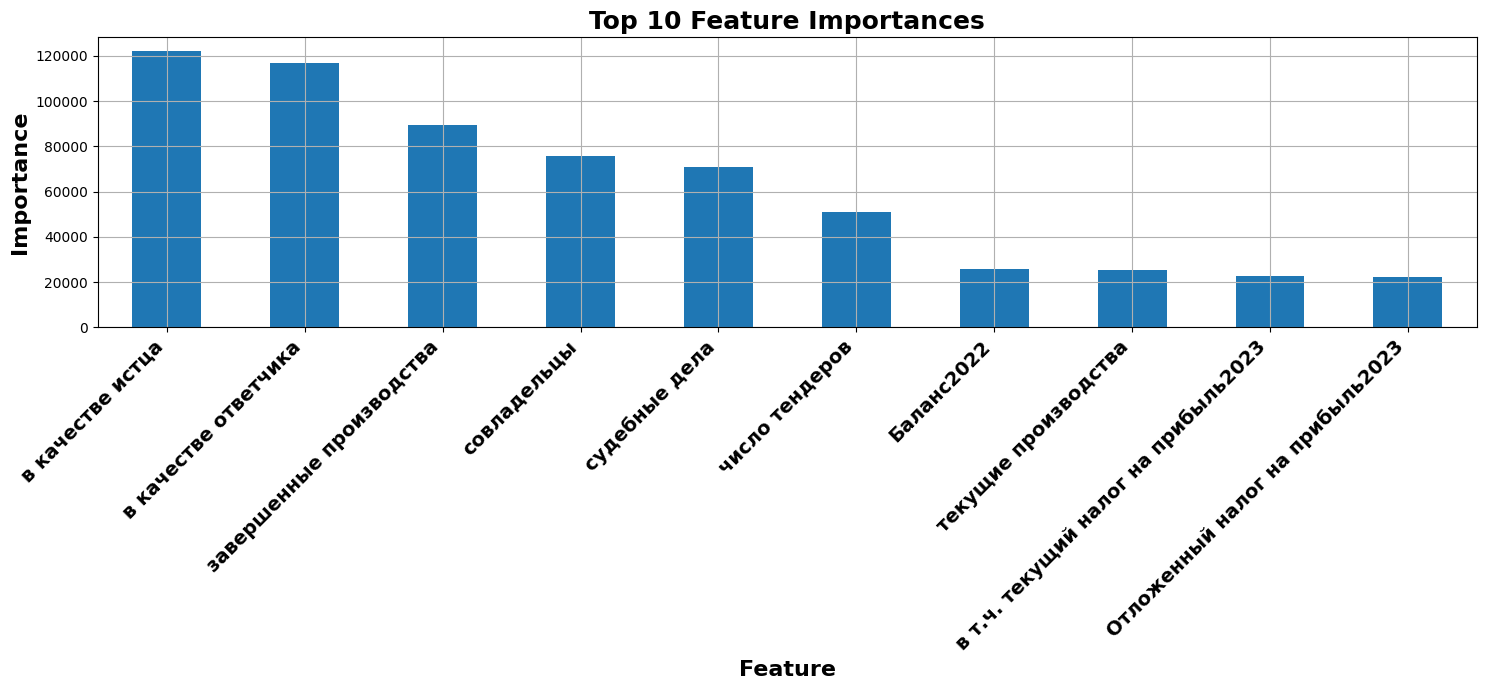

In [54]:
import matplotlib.pyplot as plt

# Получите данные для графика и выберите топ-10 фичей
fast_fi = automl.get_feature_scores('fast').head(10)

# Создайте график
fig, ax = plt.subplots(figsize=(15, 7))
fast_fi.set_index('Feature')['Importance'].plot.bar(ax=ax, grid=True)

# Поверните метки по оси X на 45 градусов для лучшей читаемости
plt.xticks(rotation=45, ha='right', fontsize=14, fontweight='bold')

# Установите параметры для меток оси Y
ax.set_ylabel('Importance', fontsize=16, fontweight='bold')
ax.set_xlabel('Feature', fontsize=16, fontweight='bold')

# Установите параметры для заголовка графика (если он нужен)
ax.set_title('Top 10 Feature Importances', fontsize=18, fontweight='bold')

# Уменьшите поля графика
plt.tight_layout()

# Сохраните график в файл
plt.savefig('feature_importance_top_10.jpg', format='jpg')

# Покажите график (не обязательно)
plt.show()


<Axes: xlabel='Feature'>

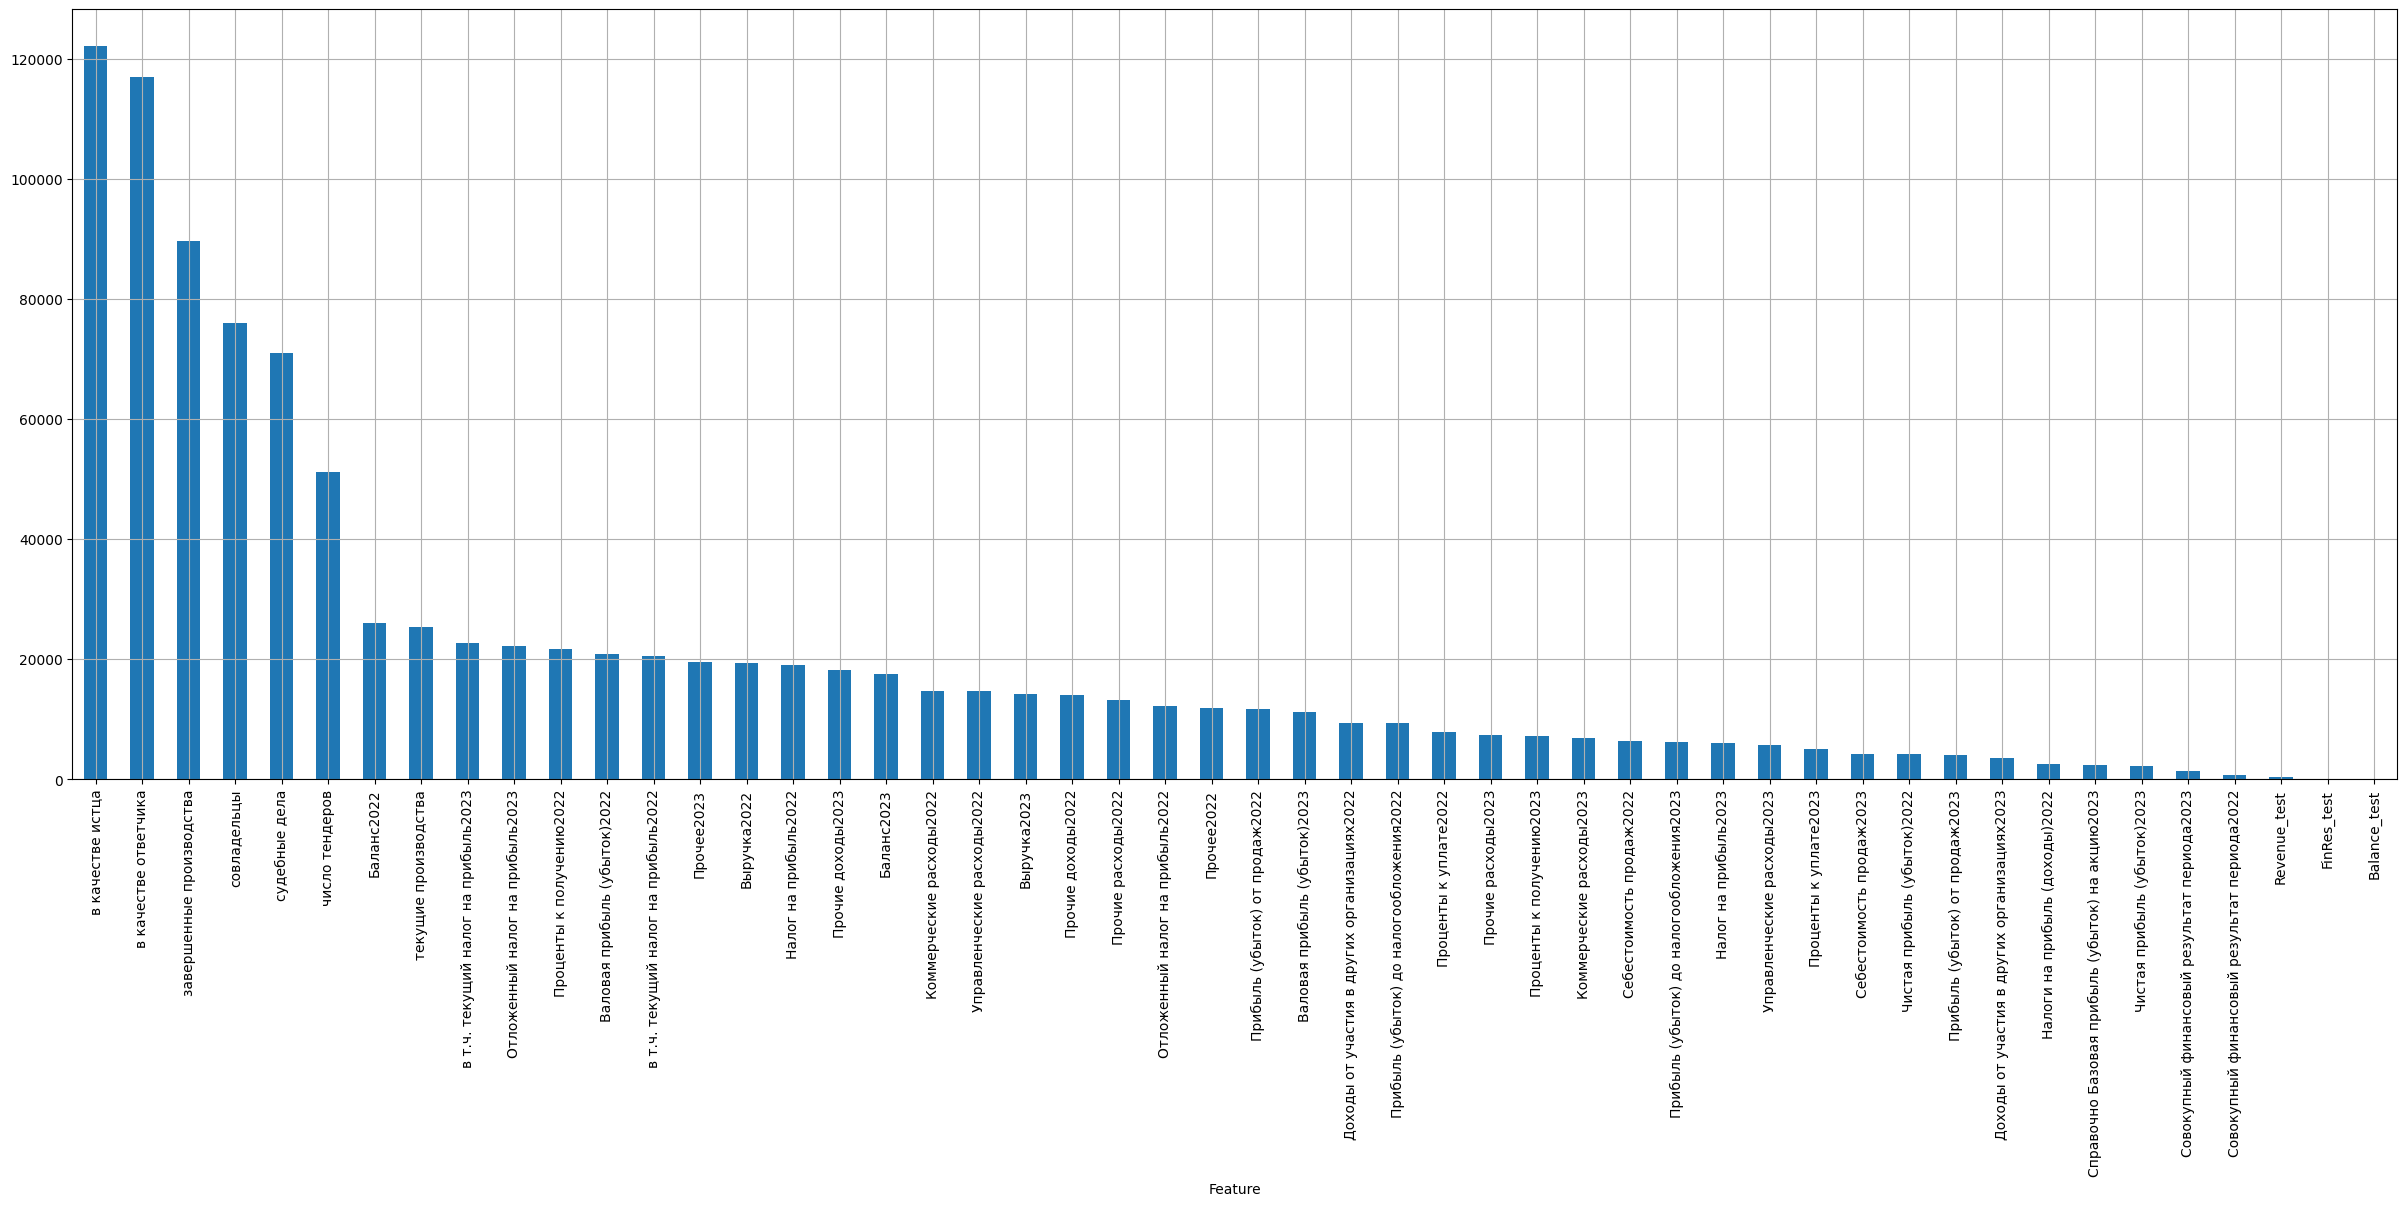

In [45]:
fast_fi = automl.get_feature_scores('fast').head(100)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
df = df.apply(LabelEncoder().fit_transform)
df['Рейтинг'] = df['Рейтинг'] + 1
train_data, test_data = train_test_split(df, 
                                    test_size=TEST_SIZE, 
                                    stratify=df[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(train_data.shape, test_data.shape))

Data splitted. Parts sizes: tr_data = (7919, 70), te_data = (880, 70)
CPU times: total: 0 ns
Wall time: 54.8 ms


In [7]:
feat_sel_0 = LGBSimpleFeatures()
mod_sel_0 = BoostLGBM()
imp_sel_0 = ModelBasedImportanceEstimator()
selector_0 = ImportanceCutoffSelector(feat_sel_0, mod_sel_0, imp_sel_0, cutoff=0, )

feats_gbm_0 = LGBAdvancedPipeline(top_intersections=4, 
                                  output_categories=True, 
                                  feats_imp=imp_sel_0)
gbm_0 = BoostLGBM()
gbm_1 = BoostLGBM()

tuner_0 = OptunaTuner(n_trials=20, timeout=30, fit_on_holdout=True)
gbm_lvl0 = MLPipeline([
        (gbm_0, tuner_0),
        gbm_1
    ],
    pre_selection=selector_0,
    features_pipeline=feats_gbm_0, 
    post_selection=None
)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
CPU times: total: 0 ns
Wall time: 1.78 ms


In [8]:
feats_reg_0 = LinearFeatures(output_categories=True, 
                             sparse_ohe='auto')

reg_0 = LinearLBFGS()

reg_lvl0 = MLPipeline([
        reg_0
    ],
    pre_selection=None,
    features_pipeline=feats_reg_0, 
    post_selection=None
)

In [9]:
task = Task('multiclass', metric = 'crossentropy', ) 
reader = PandasToPandasReader(task = task, samples = None, max_nan_rate = 1, max_constant_rate = 1,
                              advanced_roles = True, drop_score_co = -1, n_jobs = 4)
blender = WeightedBlender()
automl = AutoML(reader=reader, levels=[
    [gbm_lvl0, reg_lvl0]
], blender=blender, skip_conn=False)

In [10]:
oof_pred = automl.fit_predict(train_data, roles={'target': TARGET_NAME}, verbose = 1)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

[17:01:27] Train data shape: (7919, 70)

[17:01:37] Feats was rejected during automatic roles guess: []
[17:01:37] Layer 1 train process start. Time left 9999999989.32 secs
[17:01:38] Training until validation scores don't improve for 100 rounds
[17:01:49] LightGBM fitting and predicting completed
[17:01:49] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_LightGBM ... Time budget is 30.00 secs
[17:01:49] Training until validation scores don't improve for 100 rounds
[17:02:02] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[17:02:02] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244} scored -0.6029024442634559 in 0:00:12.309111
[17:02:02] Training until validation scores don't improve for 100 rounds
[17:02:14] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[17:02:14] Trial 2 with hyperparameters {'feature_fraction': 0.8659969709057025, 'num_leaves': 159} scored -0.6026879377993788 in 0:00:12.184533
[17:02:14] Tr

In [14]:
from sklearn.metrics import log_loss

In [15]:
%%time

test_pred = automl.predict(test_data)

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_data[TARGET_NAME].values, oof_pred.data)))
print('TEST score: {}'.format(log_loss(test_data[TARGET_NAME].values, test_pred.data)))

Check scores...
OOF score: 8.76467546257399
TEST score: 8.79726533673589
CPU times: total: 13.8 s
Wall time: 8.39 s


In [18]:
for dat, df, name in zip([oof_pred, test_pred], [train_data, test_data], ['train', 'test']):
    print('Check aucs {0}...'.format(name))
    for cl in range(1, 21):
        sc = roc_auc_score((df[TARGET_NAME].values == cl).astype(np.float32), dat.data[:, cl])
        print('Class {0} {1} auc score: {2}'.format(cl, name, sc))

Check aucs train...
Class 1 train auc score: 0.9757588386821228
Class 2 train auc score: 0.46633907871180197
Class 3 train auc score: 0.5097782467772134
Class 4 train auc score: 0.32090542570496805
Class 5 train auc score: 0.4156428008726215
Class 6 train auc score: 0.34357686251799546
Class 7 train auc score: 0.4649804163182678
Class 8 train auc score: 0.5229800772191633
Class 9 train auc score: 0.5410695767784214
Class 10 train auc score: 0.6197792124980073
Class 11 train auc score: 0.4833727352259598
Class 12 train auc score: 0.618421320572214
Class 13 train auc score: 0.9889034418642875
Class 14 train auc score: 0.5074059111511815
Class 15 train auc score: 0.5039439953569018
Class 16 train auc score: 0.5852892582063804
Class 17 train auc score: 0.4754505057029379
Class 18 train auc score: 0.6931322194429612
Class 19 train auc score: 0.6614709594694769
Class 20 train auc score: 0.49150559511698877
Check aucs test...
Class 1 test auc score: 0.9825379680544646
Class 2 test auc score: 